In [ ]:
# =========================================================
# 1. SETUP BÁSICO
# =========================================================
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho do dataset
# Link do drive: https://drive.google.com/drive/folders/1h4o-30tPOpCnMzcmd7uGvZs_JTWlVOCF?usp=drive_link
DATASET_DIR = "/content/drive/MyDrive/SPRINT4/casting_data"

# Checar estrutura
print("Estrutura de pastas:")
!ls "$DATASET_DIR"

# Definir dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estrutura de pastas:
test  train
Usando device: cpu


Classes detectadas: ['def_front', 'ok_front']
Tamanhos finais:
  Treino   : 5638
  Validação: 995
  Teste    : 715


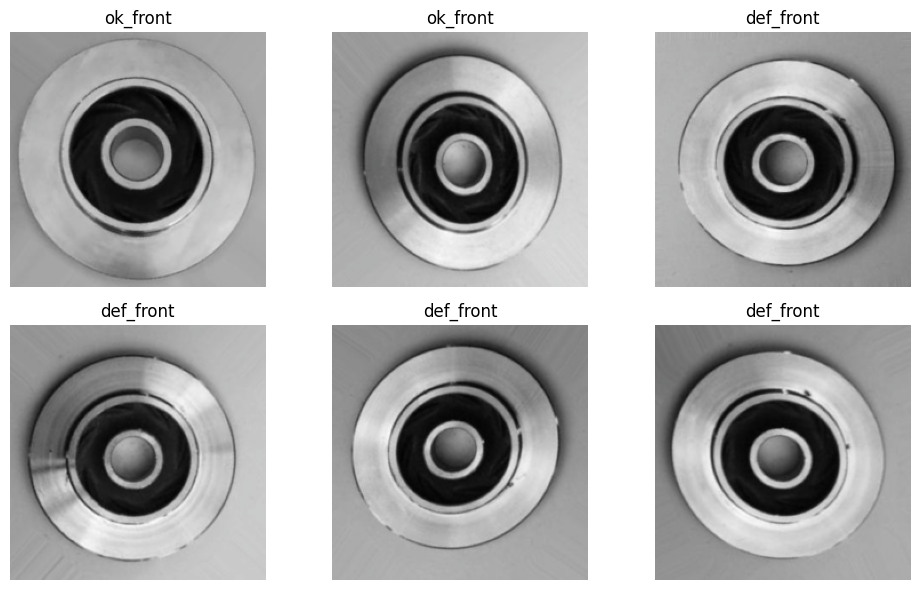

In [ ]:
# =========================================================
# 2. DATASET + TRANSFORMS + DATALOADERS
# =========================================================
# Aplicação de augmentação para o treino, de modo que o generalize e seja possivel generalizar para o aumento de sua precisão


# Caminhos para os arquivos
train_dir = os.path.join(DATASET_DIR, "train")
test_dir  = os.path.join(DATASET_DIR, "test")

# Augmentação para os treinos
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Validação e teste: sem augmentação
eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Data Sets
full_train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset       = datasets.ImageFolder(root=test_dir,  transform=eval_transform)

class_names = full_train_dataset.classes
print("Classes detectadas:", class_names) #DEBUG das classes

# Split train e val
val_ratio = 0.15
train_size = int((1 - val_ratio) * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Correção do transform
val_dataset.dataset.transform = eval_transform

print(f"Tamanhos finais:")
print("  Treino   :", len(train_dataset))
print("  Validação:", len(val_dataset))
print("  Teste    :", len(test_dataset))

# Data Loaders
batch_size = 16  # bom equilíbrio GPU/RAM
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)

# Visualização
def undo_normalize(img_tensor):
    img = img_tensor.clone().detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    return img

images, labels = next(iter(train_loader))
plt.figure(figsize=(10,6))
for i in range(min(6, len(images))):
    plt.subplot(2,3,i+1)
    plt.imshow(undo_normalize(images[i]))
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# =========================================================
# 3. MODELO CNN – TRANSFER LEARNING (MobileNetV2)
# =========================================================

# Carrega o modelo pré-treinado
model = models.mobilenet_v2(weights=True)

# Feature extractor
for param in model.features.parameters():
    param.requires_grad = False

# Substitui a camada final para 2 classes (def_front / ok_front)
num_ftrs = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 2)
)

model = model.to(device)
print("Modelo pronto:", type(model).__name__)

# Definições de treino
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Redução de taxa de aprendizado se o modelo parar de melhorar
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 128MB/s]

Modelo pronto: MobileNetV2


In [ ]:
# =========================================================
# 4. TREINAMENTO + VALIDAÇÃO
# =========================================================

# Função para treinar uma época
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in tqdm(loader, desc="Treinando", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)

    return running_loss / total, correct / total


# Função de validação
def eval_one_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validando", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)

    return running_loss / total, correct / total


# Loop principal de treinamento
num_epochs = 10
best_val_acc = 0.0
patience, patience_counter = 3, 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

start_time = time.time()

for epoch in range(num_epochs):
    print(f"\n===== Época {epoch+1}/{num_epochs} =====")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion)

    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Treino  -> Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Validação -> Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

    # Early stopping simples
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("===== Early stopping ativado =====")
            break

elapsed = time.time() - start_time
print(f"\nTreinamento concluído em {elapsed/60:.1f} min. Melhor acuracidade: {best_val_acc:.4f}")



===== Época 1/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.2378 | Acc: 0.9037
Validação -> Loss: 0.1200 | Acc: 0.9598

===== Época 2/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1483 | Acc: 0.9434
Validação -> Loss: 0.0641 | Acc: 0.9829

===== Época 3/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1358 | Acc: 0.9452
Validação -> Loss: 0.1168 | Acc: 0.9558

===== Época 4/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1168 | Acc: 0.9557
Validação -> Loss: 0.0471 | Acc: 0.9869

===== Época 5/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1295 | Acc: 0.9477
Validação -> Loss: 0.0508 | Acc: 0.9869

===== Época 6/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1410 | Acc: 0.9440
Validação -> Loss: 0.0404 | Acc: 0.9879

===== Época 7/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1262 | Acc: 0.9512
Validação -> Loss: 0.1150 | Acc: 0.9568

===== Época 8/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1252 | Acc: 0.9525
Validação -> Loss: 0.0619 | Acc: 0.9789

===== Época 9/10 =====


Treinando:   0%|          | 0/353 [00:00<?, ?it/s]

Validando:   0%|          | 0/63 [00:00<?, ?it/s]

Treino  -> Loss: 0.1268 | Acc: 0.9495
Validação -> Loss: 0.0404 | Acc: 0.9859
===== Early stopping ativado =====

Treinamento concluído em 87.0 min. Melhor acuracidade: 0.9879


Testando:   0%|          | 0/45 [00:00<?, ?it/s]


===== RELATÓRIO DE CLASSIFICAÇÃO =====
              precision    recall  f1-score   support

   def_front     0.9978    0.9868    0.9922       453
    ok_front     0.9775    0.9962    0.9868       262

    accuracy                         0.9902       715
   macro avg     0.9876    0.9915    0.9895       715
weighted avg     0.9904    0.9902    0.9902       715



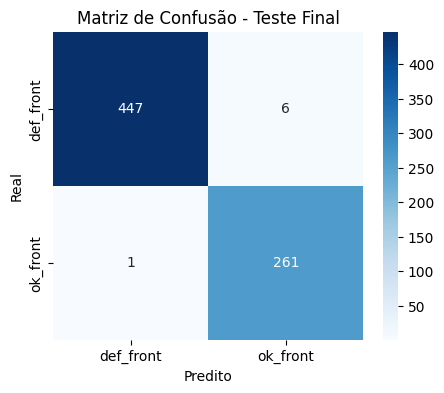


Acurácia final no conjunto de TESTE: 99.02%


In [ ]:
# =========================================================
# 5. AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
# =========================================================

# Recarrega o melhor modelo salvo
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testando", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Métricas gerais
print("\n===== RELATÓRIO DE CLASSIFICAÇÃO =====")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

# Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Teste Final")
plt.show()

# Acurácia final
test_acc = np.mean(np.array(all_labels) == np.array(all_preds))
print(f"\nAcurácia final no conjunto de TESTE: {test_acc*100:.2f}%")


Camada usada no Grad-CAM: Conv2d(960, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
Nenhum Grad-CAM gerado — tenta rodar novamente.


<Figure size 1200x400 with 0 Axes>

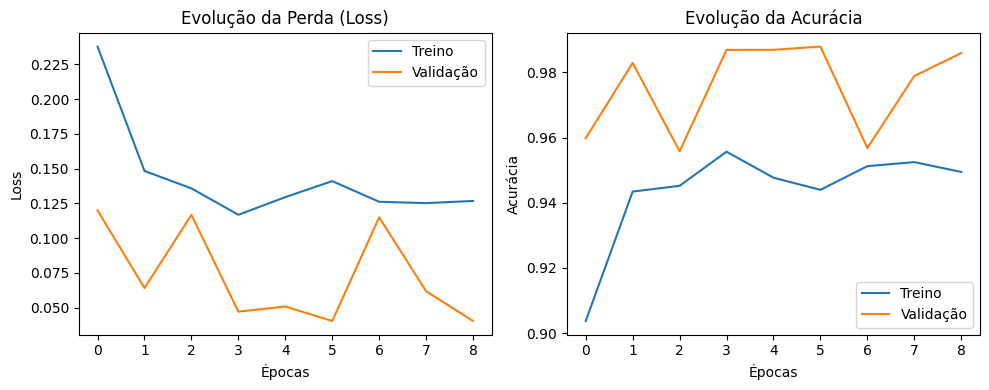

In [ ]:
# =========================================================
# 6. INTERPRETAÇÃO DO MODELO
# =========================================================

# Grad-CAM
def get_last_conv_layer(model):
    return model.features[16].conv[2]  # última convolução 3x3 útil

target_layer = get_last_conv_layer(model)
print("Camada usada no Grad-CAM:", target_layer)

def generate_gradcam(model, image_tensor, target_layer, target_class=None):
    model.eval()
    activations, gradients = [], []

    def fwd_hook(_, __, output): activations.append(output.detach())
    def bwd_hook(_, grad_in, grad_out): gradients.append(grad_out[0].detach())

    h1 = target_layer.register_forward_hook(fwd_hook)
    h2 = target_layer.register_backward_hook(bwd_hook)

    output = model(image_tensor)
    if target_class is None:
        target_class = torch.argmax(output, dim=1).item()

    model.zero_grad()
    output[0, target_class].backward()

    if not activations or not gradients:
        h1.remove(); h2.remove()
        return None

    act = activations[0].cpu()
    grad = gradients[0].cpu()
    weights = grad.mean(dim=(2,3), keepdim=True)
    cam = F.relu((weights * act).sum(dim=1)).squeeze().numpy()

    cam = cv2.resize(cam, (224,224))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    h1.remove(); h2.remove()
    return cam

# Visualização Grad-CAM
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

def show_gradcam_examples(model, loader, class_names, n=3):
    model.eval()
    imgs_done = 0
    plt.figure(figsize=(12,4))

    for imgs, _ in loader:
        imgs = imgs.to(device)
        for i in range(imgs.size(0)):
            if imgs_done >= n:
                break
            img_t = imgs[i].unsqueeze(0)
            cam = generate_gradcam(model, img_t, target_layer)
            if cam is None: continue

            img = inv_normalize(imgs[i].cpu()).permute(1,2,0).numpy()
            img = np.clip(img,0,1)
            heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = np.uint8(0.4*heatmap + 0.6*(img*255))

            pred = class_names[torch.argmax(model(img_t)).item()]
            plt.subplot(1,n,imgs_done+1)
            plt.imshow(overlay)
            plt.title(f"Pred: {pred}")
            plt.axis("off")
            imgs_done += 1
        if imgs_done >= n: break

    if imgs_done == 0:
        print("Nenhum Grad-CAM gerado — tenta rodar novamente.")
    plt.suptitle("Grad-CAM — Regiões de Atenção do Modelo", fontsize=13)
    plt.tight_layout()
    plt.show()

show_gradcam_examples(model, test_loader, class_names, n=3)

# Curvas de treinamento
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Treino")
plt.plot(val_losses, label="Validação")
plt.title("Evolução da Perda (Loss)")
plt.xlabel("Épocas"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Treino")
plt.plot(val_accs, label="Validação")
plt.title("Evolução da Acurácia")
plt.xlabel("Épocas"); plt.ylabel("Acurácia"); plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
"""

Relatório - SPRINT 4

1. Introdução

  O projeto consiste em um treinamento de um modelo de rede neural convolucional (CNN) capaz de fazer a identificação de defeitos em peças
metálicas fundidas. O uso da rede neural seria para acelerar o processo de classificação em que ele consiga garantir um processo automati-
zado, confiavel e com qualidade. A classificação do projeto foi divida em etapas, buscando interpretar a forma que o modelo se comporta u-
tilizando a tecnica GRAD-Cam, repartindo-o em duas categorias: def_front e ok_front (peça defeituosa e peça sem defeitos, respectivamente).

2. Desenvolvimento

  A partir da injeção dos datasets, repartidos em train e test, usando o Google Drive, o modelo recebe um treinamento subdivido em 85% de
treino e 15% de validação, podendo assim, garantir dados novos a cada treinamento ("época"). Para o pré processamento e aumento dos dados,
as imagens foram redimensionadas para 224x224 pixels e normalizadas conforme as médias e desvios do ImageNet, garantindo a compatibilidade
com a rede pré treinada, aplicando rotações aleatórias, espelhamento horizontal e variações de brilho e contraste, permitindo a generaliza-
ção dos dados e o aumento de sua precisão.
  O modelo empregado foi o MobileNetV2, uma rede pré treinada no ImageNet, escolhida por possuir uma alta eficiência e baixo cus-
to computacional. Utilizada em modo de transfer learning, para reaproveitar o conhecimento adquirido previamente com o conjunto de dados,
assim, permitindo a reutilização de aprendizado ja adquirido anteriormente pela rede, reduzindo o tempo de treinamento e melhorando a pre-
cisão. Outro ponto importante a citar, é a adaptação da solução para o problema encontrado na detecção de defeitos nas peças, aplicando
congelamento nas redes (não as atualizando) e aplicando uma camada final de substituição para evitar o overfitting, de modo que o modelo
atuasse como extrator de características visuais.
  Dessa forma, por fim, o modelo foi treinado por 10 épocas, usando scheduler adaptativo, assim, reduzindo automaticamente a taxa de a-
prendizado quando a perda de validação estagnava, auxiliando na estabilidade do resultado e eficiencia, repartindo os resultados em duas
classes (def_front e ok_front).

3. Insights e avaliações

  Citado anteriormente, o teste foi divido em 10 partes, para que o modelo trabalhasse em lotes e passando para frente o seu aprendizado,
para aumentar a precisão das classificações e resultados, sendo finalizado em 22 minutos com GPU e 87 minutos com a CPU (registrados no
colab e obtidos via código). Com isso, foi possivel obter 0.9899 de acurácia na melhor avaliação dos resultados, indicando que a curvatura
de perda e acuracia estão estabilizadas e generalizadas.
  Outrossim, as informações obtidas pela matriz de confusão indicaram apenas 8 erros em 715 imagens, registrando 6 casos de falso positi-
vo, classificando peças boas como defeituosas, e 2 falsos positivos, classificando peças defeituosas como boas. Conforme os dados obtidos,
é possivel considerar que o modelo possui uma alta taxa de acertivilidade e sensibilidade para detecção de defeitos.

4. Interpretação Visual pelo Grad-Cam

  Para a interpretação comportamental do modelo e identificar regiões das imagens para contribuir nas decisões de classificação, foi uti-
lizado o método Grad-Cam, que gera mapas de calor que destacam áreas de maior ativação durante a predição, fazendo com o modelo aponte
se a peça identificada é defeituosa ou não.
  Ainda que a sua implementação tenha sido feita de maneira correta, não foi possivel gerar mapas válidos devido ao congelamento de cama-
das convolucionais, feitos pelo MobileNetV2. Com isso, em um cenário futuro e de melhoria do projeto, seria interessante trabalhar o des-
congelamento das camadas de rede para que possa permitir a geração de mapas de atenção mais consistentes e interpretáveis, colaborando
para a análise e usabilidade do projeto.

5. Conclusão

  O classificador de imagens usando rede neural convolucional apresentou um desempenho elevado, atingindo 99,02% de acurácia na validação
e 98,8% nos testes, apontando uma forte capacidade de generalização dos dados e eficiência na identificação de defeitos. O modelo, baseado
em transfer learning com MobileNetV2, se mostrou eficaz na identificação de defeitos em peças fundidas, usando alta precisão com baixo
custo computacional.
  Mesmo sem a geração visual dos mapas Grad-CAM, o comportamento das métricas comprovam que a rede aprendeu de forma consistente as di-
ferenças entre as peças defeituosas ou não. Como próximos passos, é ideal o ajuste do fine-tuning nas últimas camadas, expandir a forma de
visualização para análises descongelando camadas para inserir o Grad-CAM, afim de avaliar e localizar defeitos com maior precisão.

"""